# 2 Data Wrangling<a id='2_Data_wrangling'></a>

## 2.1 Contents<a id='2.1_Contents'></a>
* [2 Data wrangling](#2_Data_wrangling)
  * [2.1 Contents](#2.1_Contents)
  * [2.2 Introduction](#2.2_Introduction)
  * [2.3 Imports](#2.3_Imports)
  * [2.4 Load the Data](#2.4_Load_the_Data)
  * [2.5 Explore the Data](#2.5_Explore_the_Data)
    * [2.5.1 Image DataFrame](#2.5.1_Image_DataFrame)
    * [2.5.2 Distribution of Labels](#2.5.2_Distribution_of_Labels)
    * [2.5.3 Image Sizes](#2.5.3_Image_Sizes)
      * [2.5.3.1 Color to Grayscale](#2.5.3.1_Color_to_Grayscale)
      * [2.5.3.2 Resize Images](#2.5.3.2_Resize_Images)
  
* [3 Exploratory Data Analysis](#3_Exploratory_Data_Analysis)
  * [3.1 Plot Sample of Images](#3.1_Plot_Sample_of_Images)
  * [3.2 Histograms of Pixel Values](#3.2_Histograms_of_Pixel_Values) 
    * [3.2.1 Descriptive Statistics](#3.2.1_Descriptive_Statistics)
    * [3.2.2 Plotting Descriptive Statistics](#3.2.2_Plotting_Descriptive_Statistics)
  * [3.3 Histogram Equalization](#3.3_Histogram_Equalization)
  * [3.4 Centering](#3.4_Centering)
  * [3.5 Save Data](#3.5_Save_Data)


## 2.2 Introduction<a id='2.2_Introduction'></a>

It is estimated that 3.6 billion diagnostic x-ray examinations are performed every year in the world. The chest x-ray is the most performed diagnostic x-ray examination. A chest x-ray produces images of the heart, lungs, airways, blood vessels and the bones of the spine and chest. A chest x-ray is typically the first imaging test used to help diagnose symptoms such as:
 - breathing difficulties
 - a bad or persistent cough
 - chest pain or injury
 - fever <br> 

Radiologists’ accuracy varies depending on what condition is being diagnosed. For example, pneumonia is accurately diagnosed from a chest x-ray around 85% of the time. Studies have also shown that there is disagreement in the interpretation of x-rays in up to 56% of cases.<br>

With so much manpower being used to assess x-rays, around the world, each year, it would be beneficial to use a machine learning model to do the initial assessment and flag which x-rays have abnormalities. The goal of this project is to create a model that is more accurate than doctors with only a chest x-ray.

The data for this project can be found at: https://www.kaggle.com/tawsifurrahman/covid19-radiography-database


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [42]:
! unzip '/content/drive/MyDrive/COVID-19_Radiography_Database.zip'

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6711.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6712.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6713.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6714.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6715.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6716.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6717.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6718.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6719.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-672.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6720.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6721.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6722.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6723.png  
  inflating:

In [43]:
!mv '/content/COVID-19_Radiography_Dataset/Viral Pneumonia' /content/COVID-19_Radiography_Dataset/Viral_Pneumonia

## 2.3 Imports<a id='2.3_Imports'></a>

In [44]:
# import the necessary libraries
import glob
import pandas as pd
import os
import numpy as np
import imageio
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.ndimage as ndi 
from skimage import data, color, exposure
from skimage.transform import resize
from collections import Counter
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import cv2
import warnings

## 2.4 Load the Data<a id='2.4_Load_the_Data'></a>

In [45]:
# setting the folders for each image type
covid_folder=os.listdir('/content/COVID-19_Radiography_Dataset/COVID')
normal_folder=os.listdir('/content/COVID-19_Radiography_Dataset/Normal')
pneumonia_folder=os.listdir('/content/COVID-19_Radiography_Dataset/Viral_Pneumonia')
lung_opacity_folder=os.listdir('/content/COVID-19_Radiography_Dataset/Lung_Opacity')

In [46]:
# setting file paths
covid_path='/content/COVID-19_Radiography_Dataset/COVID/'
normal_path='/content/COVID-19_Radiography_Dataset/Normal/'
pneumonia_path='/content/COVID-19_Radiography_Dataset/Viral_Pneumonia/'
lung_opacity_path='/content/COVID-19_Radiography_Dataset/Lung_Opacity/'

In [47]:
# read in the metadata file for each lung type
covid = pd.read_excel('/content/COVID-19_Radiography_Dataset/COVID.metadata.xlsx')
normal = pd.read_excel('/content/COVID-19_Radiography_Dataset/Normal.metadata.xlsx')
lo = pd.read_excel('/content/COVID-19_Radiography_Dataset/Lung_Opacity.metadata.xlsx')
pneumonia = pd.read_excel('/content/COVID-19_Radiography_Dataset/Viral Pneumonia.metadata.xlsx')

metadata = [covid, normal, lo, pneumonia]

In [48]:
# define a function to get the image path give the file name
def get_path(file_name):
  if file_name.startswith('C'):
    return covid_path+file_name
  elif file_name.startswith('N'):
    return normal_path+file_name
  elif file_name.startswith('V'):
    return pneumonia_path+file_name
  elif file_name.startswith('L'):
    return lung_opacity_path+file_name

In [49]:
# define a function that shows an image given the file name or image path
def show_image(image, title='Image', cmap_type='gray', path_defined=False): 
  if path_defined==False:
    path = get_path(image)
    image= imageio.imread(path)
    plt.imshow(image, cmap=cmap_type)        
    plt.title(title)    
    plt.axis('off')    
    plt.show()
  elif get_path==True:
    image = imageio.imread(image)
    plt.imshow(image, cmap=cmap_type)        
    plt.title(title)    
    plt.axis('off')    
    plt.show()

In [50]:
get_path('Lung_Opacity-1143.png')

'/content/COVID-19_Radiography_Dataset/Lung_Opacity/Lung_Opacity-1143.png'

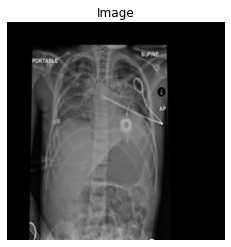

In [51]:
show_image('Lung_Opacity-1143.png')

## 2.5 Explore the Data<a id='2.5_Explore_the_Data'></a>

In [52]:
# look at the first 5 rows of each metadata file
pd.set_option('display.max_columns', None)

for m in metadata:
  print(m.head())

  FILE NAME FORMAT     SIZE                                                URL
0   COVID-1    PNG  256*256  https://sirm.org/category/senza-categoria/covi...
1   COVID-2    PNG  256*256  https://sirm.org/category/senza-categoria/covi...
2   COVID-3    PNG  256*256  https://sirm.org/category/senza-categoria/covi...
3   COVID-4    PNG  256*256  https://sirm.org/category/senza-categoria/covi...
4   COVID-5    PNG  256*256  https://sirm.org/category/senza-categoria/covi...
  FILE NAME FORMAT     SIZE                                                URL
0  NORMAL-1    PNG  256*256  https://www.kaggle.com/c/rsna-pneumonia-detect...
1  NORMAL-2    PNG  256*256  https://www.kaggle.com/c/rsna-pneumonia-detect...
2  NORMAL-3    PNG  256*256  https://www.kaggle.com/c/rsna-pneumonia-detect...
3  NORMAL-4    PNG  256*256  https://www.kaggle.com/c/rsna-pneumonia-detect...
4  NORMAL-5    PNG  256*256  https://www.kaggle.com/c/rsna-pneumonia-detect...
        FILE NAME FORMAT     SIZE  \
0  Lung_Opacity

Just by looking at the head of each of the metadata files, these are not very useful. I will create a new dataframe from the image info.

### 2.5.1 Image DataFrame<a id='2.5.1_Image_DataFrame'></a>

First, let's look at a few of the images

In [53]:
sample = ['COVID-1.png', 'COVID-10.png', 'COVID-199.png', 'COVID-1015.png', 
          'Normal-1.png', 'Normal-958.png', 'Normal-10004.png', 'Normal-10012.png', 
          'Lung_Opacity-4026.png', 'Lung_Opacity-1001.png', 'Lung_Opacity-10.png', 'Lung_Opacity-1143.png',
          'Viral Pneumonia-400.png', 'Viral Pneumonia-1003.png', 'Viral Pneumonia-486.png', 'Viral Pneumonia-101.png']

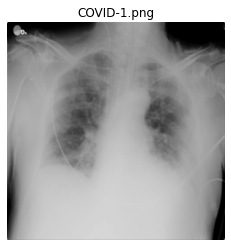

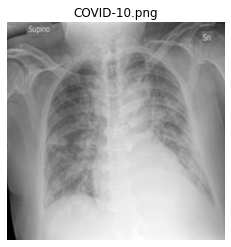

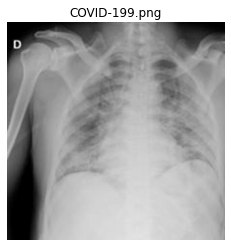

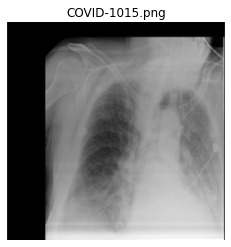

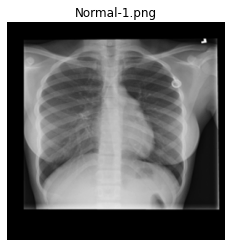

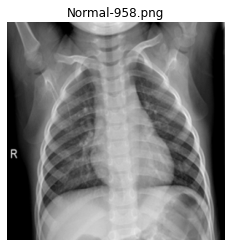

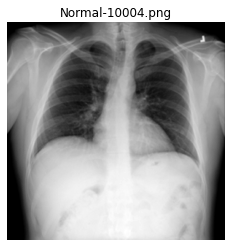

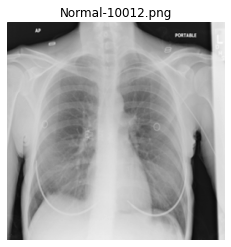

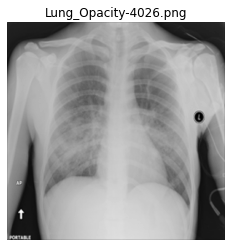

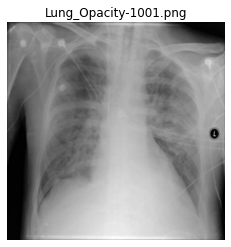

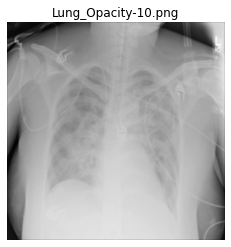

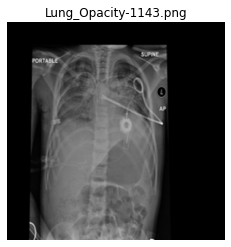

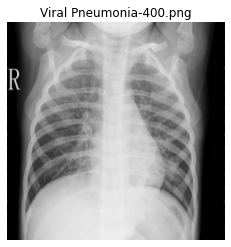

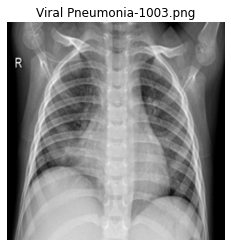

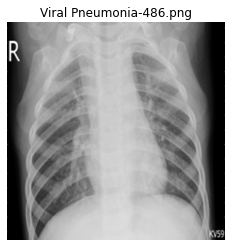

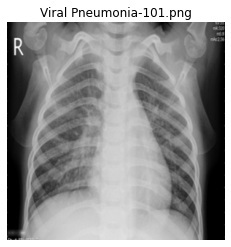

In [54]:
for s in sample:
  show_image(s, str(s))

In [55]:
# create dataframes of the images and labels
cov=list(zip(covid_folder,['covid']*(len(covid_folder))))
covid_df = pd.DataFrame(cov,columns=['file','label']) 

norm=list(zip(normal_folder,['normal']*(len(normal_folder))))
normal_df = pd.DataFrame(norm,columns=['file','label']) 

viral_pneumonia=list(zip(pneumonia_folder,['pneumonia']*(len(pneumonia_folder))))
pneumonia_df = pd.DataFrame(viral_pneumonia,columns=['file','label']) 

lung_opacity=list(zip(lung_opacity_folder,['lung_opacity']*(len(lung_opacity_folder))))
lung_opacity_df = pd.DataFrame(lung_opacity,columns=['file','label']) 
lung_opacity_df.head()

file         label
0  Lung_Opacity-3811.png  lung_opacity
1  Lung_Opacity-3627.png  lung_opacity
2  Lung_Opacity-1868.png  lung_opacity
3  Lung_Opacity-2945.png  lung_opacity
4  Lung_Opacity-4275.png  lung_opacity

In [56]:
# combine the seperate dataframes into a single dataframe
df=pd.concat([covid_df, normal_df, pneumonia_df, lung_opacity_df])
df.sample(10)

file         label
3813        Normal-8692.png        normal
28           COVID-2747.png         covid
4496  Lung_Opacity-1898.png  lung_opacity
2796  Lung_Opacity-4771.png  lung_opacity
846         Normal-2580.png        normal
8712        Normal-5416.png        normal
2737         COVID-3588.png         covid
2186  Lung_Opacity-5861.png  lung_opacity
2738          COVID-173.png         covid
1513        Normal-2112.png        normal

### 2.5.2 Distribution of Labels<a id='2.5.2_Distribution_of_Labels'></a>

In [57]:
print(df.label.value_counts())

normal          10192
lung_opacity     6012
covid            3616
pneumonia        1345
Name: label, dtype: int64


Text(0.5, 1.0, 'Number of Images in Each Label')

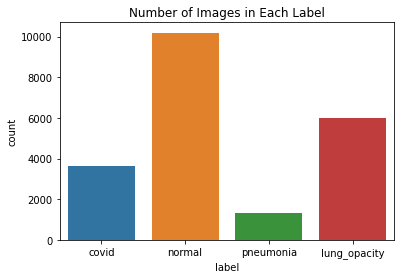

In [58]:
sns.countplot(x=df.label)
plt.title('Number of Images in Each Label')

This dataset is unbalanced with significantly less viral pneumonia cases and normal cases making up 48% of the dataset. For now I am not going to balance the set.

### 2.5.3 Image Sizes<a id='2.5.3_Image_Sizes'></a>

In [59]:
# add the file path to the dataframe
path = []

for row in df.values:
  path.append(get_path(row[0]))

df['path'] = path

In [60]:
# add the size of each image to the dataframe
size = []

for row in df.values:
    image = imageio.imread(row[2])
    size.append(image.shape)

df['size'] = size

pd.Series(size).value_counts()

(299, 299)       21025
(299, 299, 3)      140
dtype: int64

In [61]:
dtypes = []

for row in df.values:
    image = imageio.imread(row[2])
    dtypes.append(image.dtype)

Counter(dtypes).keys() # equals to list(set(words))

dict_keys([dtype('uint8')])

#### 2.5.3.1 Color to Grayscale<a id='2.5.3.1_Color_to_Grayscale'></a>

Here I need to convert the 140 color images to grayscale

In [62]:
color_mask = df[df['size'] == (299, 299, 3)]
color_mask.sample(4)

file      label  \
418   Viral Pneumonia-208.png  pneumonia   
1224  Viral Pneumonia-430.png  pneumonia   
707   Viral Pneumonia-817.png  pneumonia   
404   Viral Pneumonia-635.png  pneumonia   

                                                   path           size  
418   /content/COVID-19_Radiography_Dataset/Viral_Pn...  (299, 299, 3)  
1224  /content/COVID-19_Radiography_Dataset/Viral_Pn...  (299, 299, 3)  
707   /content/COVID-19_Radiography_Dataset/Viral_Pn...  (299, 299, 3)  
404   /content/COVID-19_Radiography_Dataset/Viral_Pn...  (299, 299, 3)

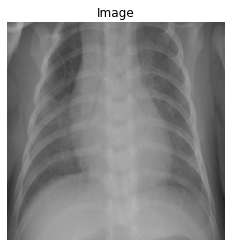

In [63]:
show_image('Viral Pneumonia-655.png')

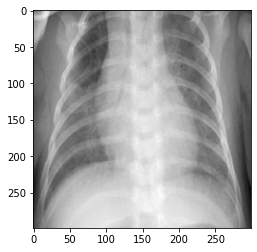

In [64]:
path = get_path('Viral Pneumonia-655.png')
image = imageio.imread(path)
gray = color.rgb2gray(image)
plt.imshow(gray, cmap='gray')

In [65]:
gray.shape

(299, 299)

In [66]:
index = []

for row in color_mask.iterrows():
  index.append(row[0])
  path = row[1]['path']
  image = imageio.imread(path)
  gray_image = color.rgb2gray(image)
  imageio.imwrite(path, gray_image)

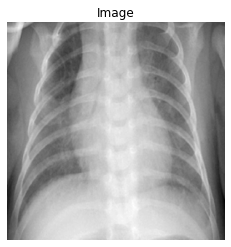

In [67]:
show_image('Viral Pneumonia-655.png')

#### 2.5.3.2 Resize Images<a id='2.5.3.2_Resize_Images'></a>

Resize all of the images to size 150x150

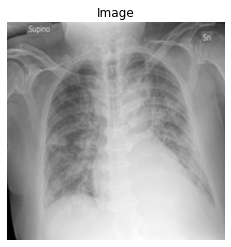

In [68]:
show_image(sample[1])

Text(0.5, 1.0, 'Resized Image')

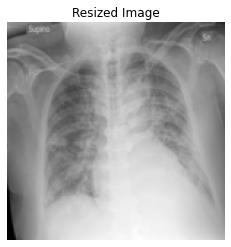

In [69]:
path = get_path(sample[1])
image = imageio.imread(path)
height = int(image.shape[0] / 2)
width = int(image.shape[1] / 2)
resize_image = resize(image, (height, width))
plt.imshow(resize_image, cmap='gray')
plt.axis('off')
plt.title('Resized Image')

In [70]:
resize_image.shape

(149, 149)

In [71]:
# resize all image to half the original size
for row in df.values:
  path = row[2]
  image = imageio.imread(path)
  height = int(image.shape[0] / 2)
  width = int(image.shape[1] / 2)
  resize_image = resize(image, (height, width))
  imageio.imwrite(path, resize_image)

Streaming output truncated to the last 5000 lines.


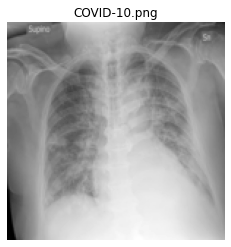

In [72]:
show_image(sample[1], sample[1])

# 3 Exploratory Data Analysis<a id='3_Exploratory_Data_Analysis'></a>

## 3.1 Plot Sample of Images<a id='3.1_Plot_Sample_of_Images'></a>

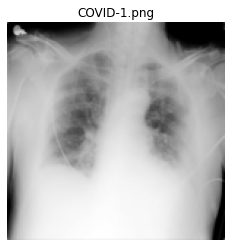

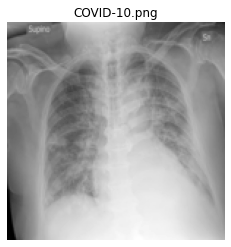

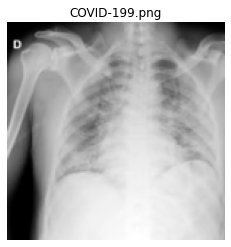

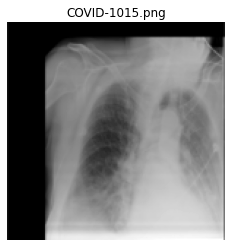

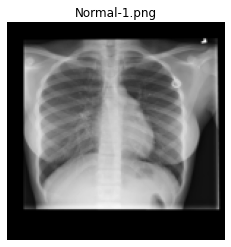

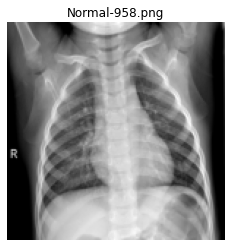

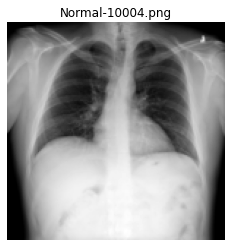

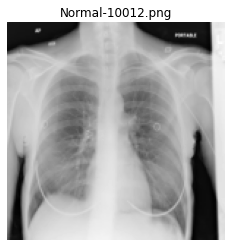

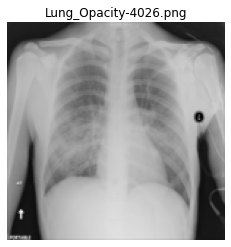

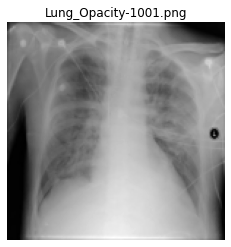

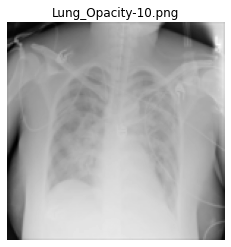

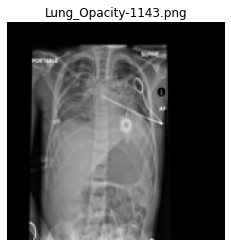

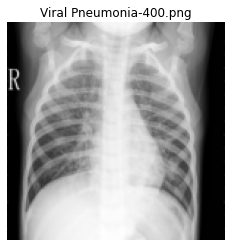

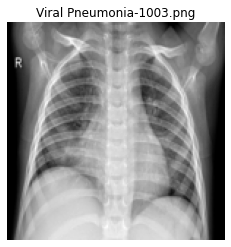

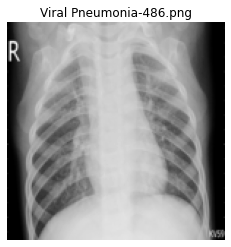

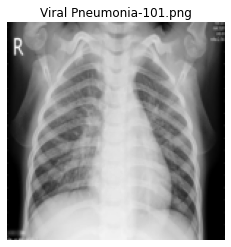

In [73]:
for s in sample:
  show_image(s,s)

Looking at the sample of images, I can see that not all images are centered in the frame. Also, some of the images' pixel values look like they could use equalization. I am going to look at the pixel histograms for each sample image.

## 3.2 Histograms of Pixel Values<a id='3.2_Histograms_of_Pixel_Values'></a>

---



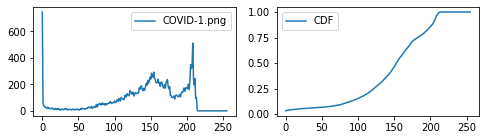

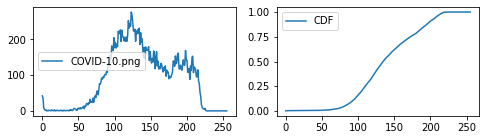

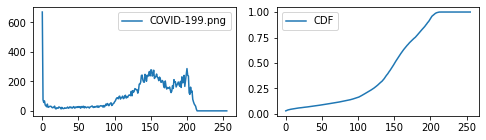

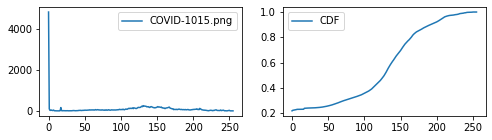

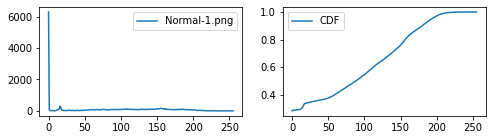

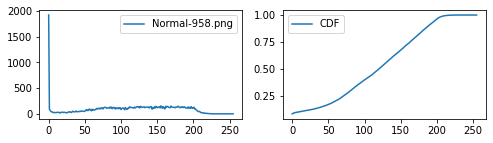

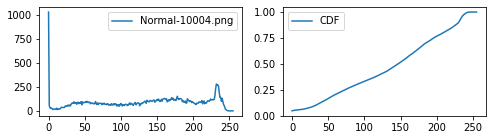

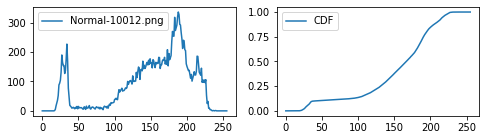

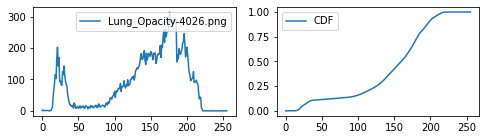

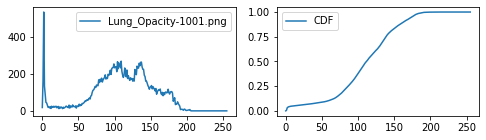

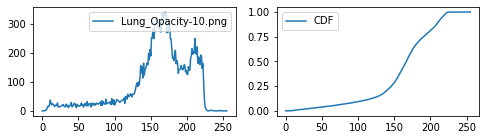

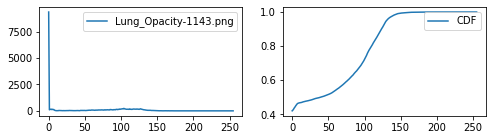

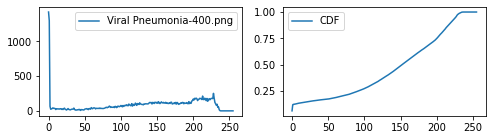

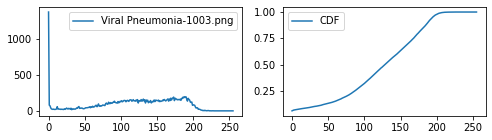

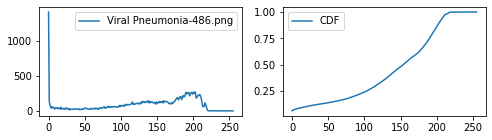

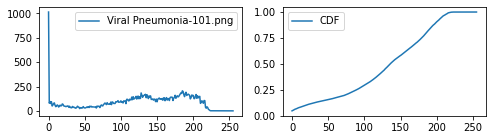

In [74]:
for s in sample:
  path = get_path(s)
  title = s
  image = imageio.imread(path)
  hist = ndi.histogram(image, min=0, max=255, bins=256)
  cdf = hist.cumsum() / hist.sum()

  fig, axes = plt.subplots(1, 2)
  fig.set_size_inches(8, 2)
  axes[0].plot(hist, label = title)
  axes[1].plot(cdf, label = 'CDF')

  axes[0].legend()
  axes[1].legend()

  plt.show()

### 3.2.1 Descriptive Statistics<a id='3.2.1_Descriptive_Statistics'></a>

It would be helpful to have some descriptive statistics for each image. Here I will add minimum, maximum, mean and standard deviation of the pixel values for each image. 

In [75]:
min = []
max = []
mean = []
std = []

for row in df.values:
  path = row[2]
  image = imageio.imread(path)
  min.append(image.min())
  max.append(image.max())
  mean.append(image.mean())
  std.append(image.std())

df['min'] = min
df['max'] = max
df['mean'] = mean
df['std'] = std

In [76]:
df.head()

file  label                                               path  \
0  COVID-2007.png  covid  /content/COVID-19_Radiography_Dataset/COVID/CO...   
1   COVID-703.png  covid  /content/COVID-19_Radiography_Dataset/COVID/CO...   
2  COVID-2642.png  covid  /content/COVID-19_Radiography_Dataset/COVID/CO...   
3  COVID-2705.png  covid  /content/COVID-19_Radiography_Dataset/COVID/CO...   
4  COVID-1375.png  covid  /content/COVID-19_Radiography_Dataset/COVID/CO...   

         size  min  max        mean        std  
0  (299, 299)    0  249  158.196523  45.947573  
1  (299, 299)    1  254  173.461015  38.452228  
2  (299, 299)    3  255  137.393721  53.954070  
3  (299, 299)    0  255  131.571866  96.437761  
4  (299, 299)    0  255  142.114409  81.153156

### 3.2.2 Plotting Descriptive Statistics<a id='3.2.2_Plotting_Descriptive_Statistics'></a>

Now I am going to plot some of the descriptive statistics to see if they differ per label.

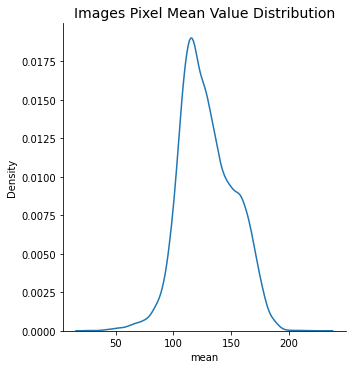

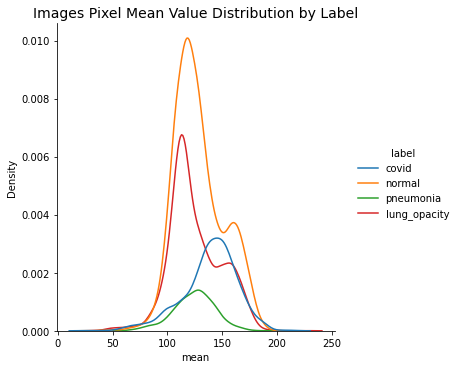

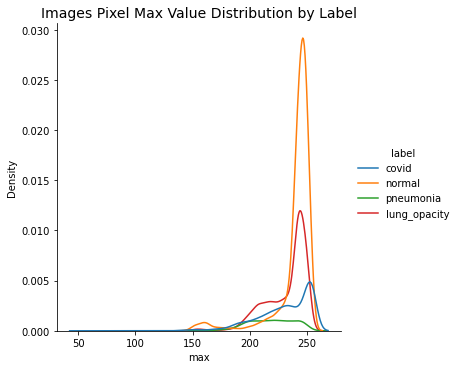

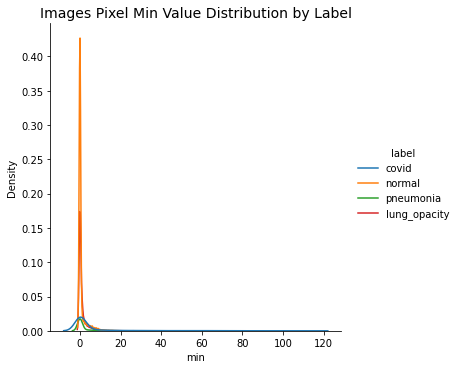

In [77]:
ax = sns.displot(data = df, x = 'mean', kind="kde");
plt.title('Images Pixel Mean Value Distribution', fontsize = 14);
ax = sns.displot(data = df, x = 'mean', kind="kde", hue = 'label');
plt.title('Images Pixel Mean Value Distribution by Label', fontsize = 14);
ax = sns.displot(data = df, x = 'max', kind="kde", hue = 'label');
plt.title('Images Pixel Max Value Distribution by Label', fontsize = 14);
ax = sns.displot(data = df, x = 'min', kind="kde", hue = 'label');
plt.title('Images Pixel Min Value Distribution by Label', fontsize = 14);

Next, I am going to look at the mean pixel value vs the standard deviation, using the images as points. This plot is a great way to visualize how the difference in standard deviation, and mean values, impact the image.

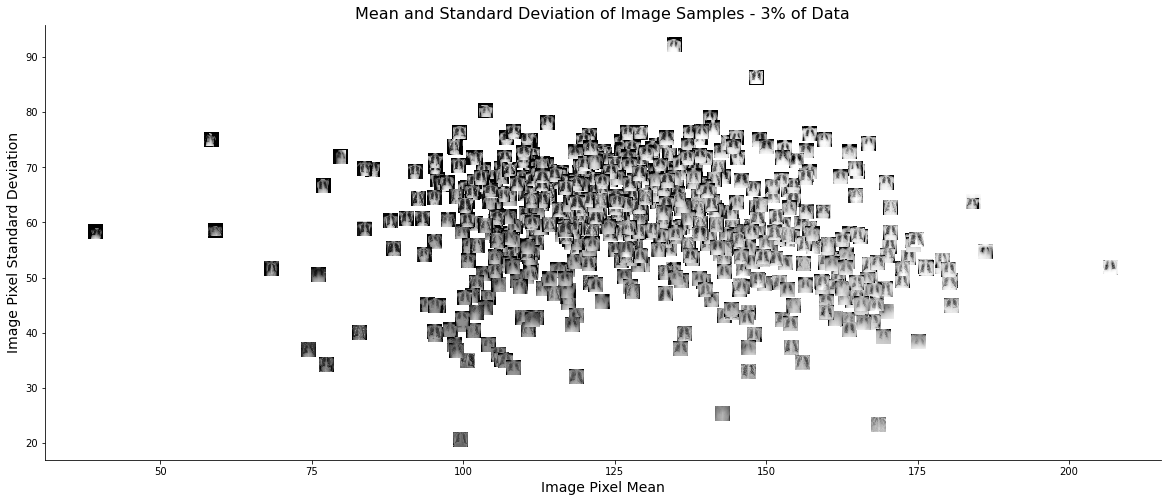

In [78]:
# taken from https://www.kaggle.com/jnegrini/covid-19-radiography-data-eda-and-cnn-model#3.-CNN-Model
# inspired by a talk at PyData 2016, by Mehrdad Yazdani with the title Using Exploratory Data Analysis to Discover Patterns
def getImage(path):
    return OffsetImage(cv2.imread(path),zoom = 0.1)

df_sample = df.sample(frac=0.03, replace=False, random_state=1)
paths = df_sample['path']

fig, ax = plt.subplots(figsize=(20,8))
ab = sns.scatterplot(data=df_sample, x="mean", y='std')
sns.despine(top=True, right=True, left=False, bottom=False)
ax.set_xlabel('Image Pixel Mean',fontsize = 14)
ax.set_ylabel('Image Pixel Standard Deviation',fontsize = 14)
plt.title('Mean and Standard Deviation of Image Samples - 3% of Data', fontsize = 16);

for x0, y0, path in zip(df_sample['mean'], df_sample['std'],paths):
    ab = AnnotationBbox(getImage(path), (x0, y0), frameon=False)
    ax.add_artist(ab)

## 3.3 Histogram Equalization<a id='3.3_Histogram_Equalization'></a>

Here I am going to look into equalizing the images.

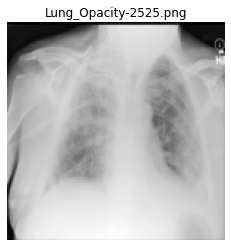

In [79]:
file = 'Lung_Opacity-2525.png'
show_image(file, file)

Text(0.5, 1.0, 'Lung_Opacity-2525.png Pixel Histogram')

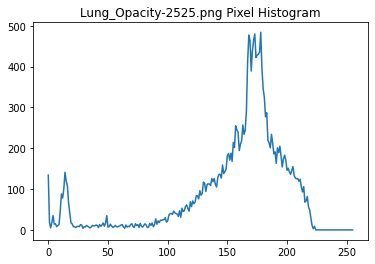

In [80]:
# plot the histogram for the original image
path = get_path(file)
title = file
image = imageio.imread(path)
hist = ndi.histogram(image, min=0, max=255, bins=256)
plt.plot(hist)
plt.title(file+' Pixel Histogram')

Text(0.5, 1.0, 'Equalized Image')

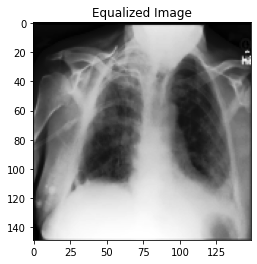

In [81]:
# Use histogram equalization to improve the contrast
xray_image_eq =  exposure.equalize_hist(image)

# show the equalized image
plt.imshow(xray_image_eq, cmap='gray')
plt.title('Equalized Image')

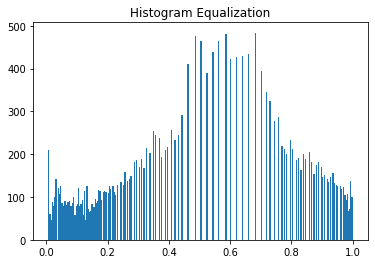

In [82]:
# plot the equalized histogram
plt.hist(xray_image_eq.ravel(), bins=256)
plt.title('Histogram Equalization')
plt.show()

Text(0.5, 1.0, 'Adaptive Equalized Image')

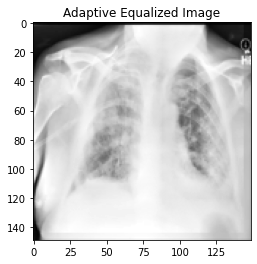

In [83]:
# Apply adaptive Equalization
image_adapteq = exposure.equalize_adapthist(image, clip_limit=0.01)

# show image
plt.imshow(image_adapteq, cmap='gray')
plt.title('Adaptive Equalized Image')

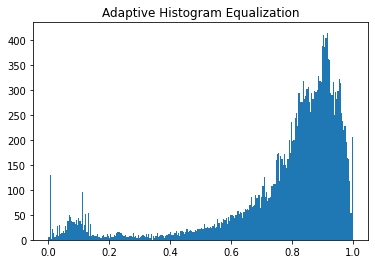

In [84]:
# plot the adaptive equalization histogram
plt.hist(image_adapteq.ravel(), bins=256)
plt.title('Adaptive Histogram Equalization')
plt.show()

From these, it looks like adaptive equalization has already been done. I am not sure if any equalization will help with the model. I am going to look at another example before deciding.

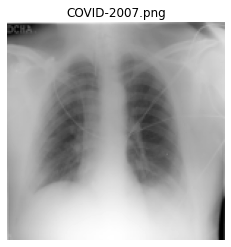

In [85]:
sample_file_path = 'COVID-2007.png'

show_image(sample_file_path, sample_file_path)

Text(0.5, 1.0, 'Lung_Opacity-2525.png Pixel Histogram')

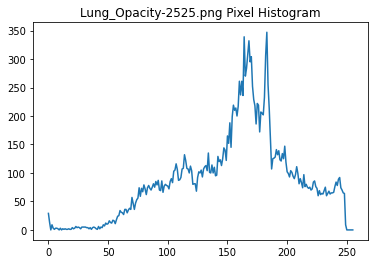

In [86]:
# plot the histogram of the original image
path = get_path(sample_file_path)
title = sample_file_path
image = imageio.imread(path)
hist = ndi.histogram(image, min=0, max=255, bins=256)
plt.plot(hist)
plt.title(file+' Pixel Histogram')

Text(0.5, 1.0, 'Equalized Image')

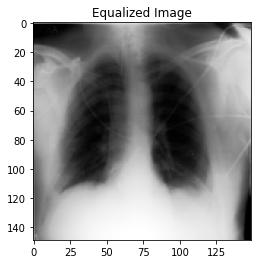

In [87]:
# Use histogram equalization to improve the contrast
xray_image_eq =  exposure.equalize_hist(image)

# show the equalized image
plt.imshow(xray_image_eq, cmap='gray')
plt.title('Equalized Image')

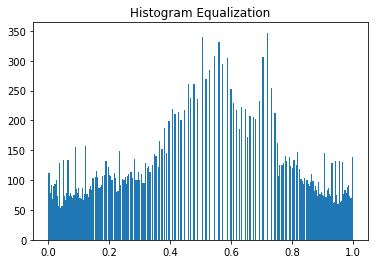

In [88]:
# plot the equalized image histogram
plt.hist(xray_image_eq.ravel(), bins=256)
plt.title('Histogram Equalization')
plt.show()

Text(0.5, 1.0, 'Adaptive Equalized Image')

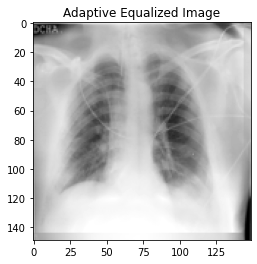

In [89]:
# Apply adaptive Equalization
image_adapteq = exposure.equalize_adapthist(image, clip_limit=0.01)

# show image
plt.imshow(image_adapteq, cmap='gray')
plt.title('Adaptive Equalized Image')

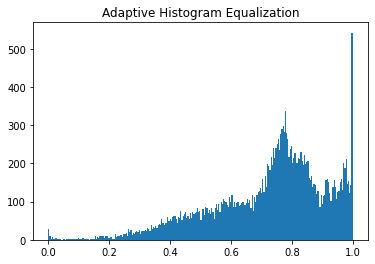

In [90]:
# plot the adaptive equalization histogram
plt.hist(image_adapteq.ravel(), bins=256)
plt.title('Adaptive Histogram Equalization')
plt.show()

From the second sample, I am still not sure if equalization will be necessary. I am not going to equalize the images at this time. 

## 3.4 Centering<a id='3.4_Centering'></a>

I am now going to calculate the center of mass for each image.

In [91]:
# create empty lists that will store the center values
center_0 = []
center_1 = []

# find the center of mass for each image
for row in df.values:
  path = row[2]
  image = imageio.imread(path)
  center = ndi.center_of_mass(image)
  center_0.append(center[0])
  center_1.append(center[1])

# add the center to the dataframe
df['center_0'] = center_0
df['center_1'] = center_1
df.sample(5)

file         label  \
2099         Normal-309.png        normal   
112   Lung_Opacity-4501.png  lung_opacity   
217         Normal-9281.png        normal   
1568  Lung_Opacity-4648.png  lung_opacity   
1175  Lung_Opacity-3079.png  lung_opacity   

                                                   path        size  min  max  \
2099  /content/COVID-19_Radiography_Dataset/Normal/N...  (299, 299)    0  247   
112   /content/COVID-19_Radiography_Dataset/Lung_Opa...  (299, 299)    3  246   
217   /content/COVID-19_Radiography_Dataset/Normal/N...  (299, 299)    0  246   
1568  /content/COVID-19_Radiography_Dataset/Lung_Opa...  (299, 299)    1  240   
1175  /content/COVID-19_Radiography_Dataset/Lung_Opa...  (299, 299)    0  244   

            mean        std   center_0   center_1  
2099  125.185307  60.709616  76.636663  75.932981  
112   165.641458  40.313420  81.901781  73.747302  
217   120.914959  65.893034  79.650796  76.120018  
1568  142.809333  71.377663  76.994742  83.038946  
1175  136.852484  59.128416  86.322006  77.488898

A centered image would have the center at 74.5. It looks like 'Viral Pneumonia-1000.png' is pretty close to center while 'Normal-9560.png' is not centered. Let's take a look at both of these now.

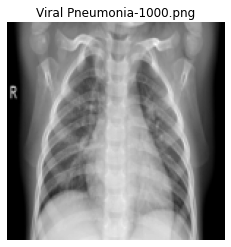

In [92]:
show_image('Viral Pneumonia-1000.png', 'Viral Pneumonia-1000.png')

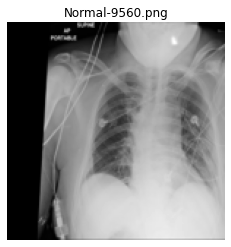

In [93]:
show_image('Normal-9560.png', 'Normal-9560.png')

I am going to look at 'Normal-9560.png' again, shifted toward the center.

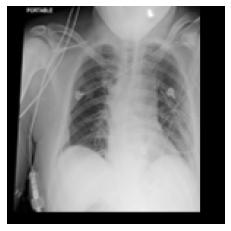

In [94]:
# read the image
path = get_path('Normal-9560.png')
im = imageio.imread(path)

center = ndi.center_of_mass(im)

# Calculate amount of shift needed
d0 = 74.5 - center[0]
d1 = 74.5 - center[1]

# Translate towards the center
xfm = ndi.shift(im, shift=(d0, d1))

# show the shifted image
plt.imshow(xfm, cmap='gray')
plt.axis('off')
plt.show()

In [95]:
ndi.center_of_mass(xfm)

(76.98390937355099, 73.86903860407149)

Here I am going to plot where the centers of each image are, by label. 

Text(0.5, 1.0, 'Center of Images by Label')

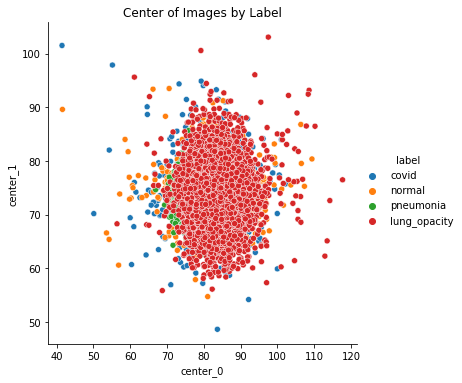

In [96]:
sns.relplot(x='center_0', y='center_1', data=df, hue='label')
plt.title('Center of Images by Label')

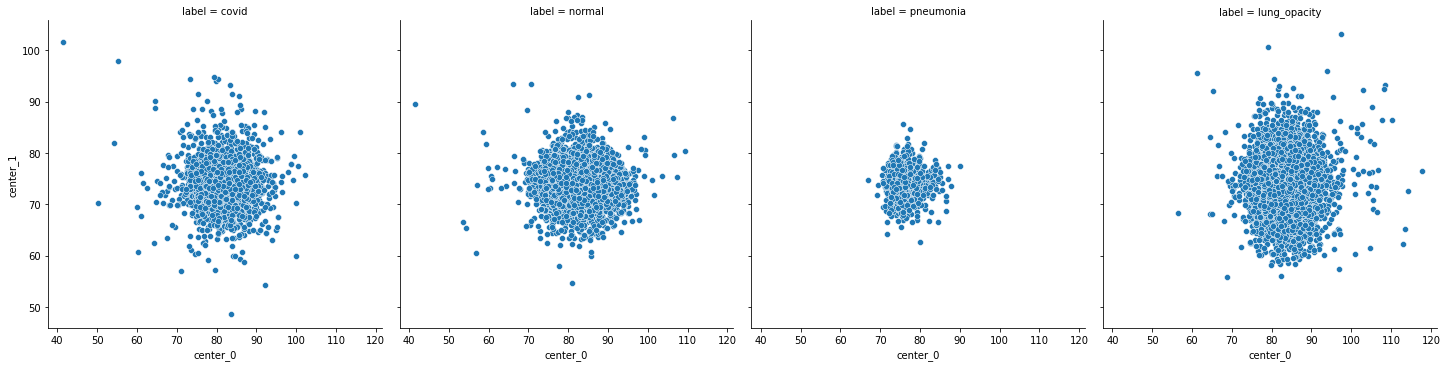

In [97]:
# plot each of the labels seperately
sns.relplot(x='center_0', y='center_1', data=df, col='label')

From these plots, it looks like the pneumonia images are the most centered. The lung opacity images have centers that are more spread out. I am now going to re-center all of the images.

In [98]:
for row in df.values:
  # read the image
  path = row[2]
  im = imageio.imread(path)

  # Calculate amount of shift needed
  d0 = 74.5 - row[8]
  d1 = 74.5 - row[9]

  # Translate towards the center
  xfm = ndi.shift(im, shift=(d0, d1))

  # save the image
  imageio.imwrite(path, xfm)

In [99]:
for s in sample:
  # read the image
  path = get_path(s)
  im = imageio.imread(path)

  print(ndi.center_of_mass(im))

(76.03822971044302, 74.04768783801444)
(76.9148753067289, 75.524548971885)
(75.83085680564396, 75.62868429079143)
(74.23201823489764, 74.36883567542053)
(74.49562246650783, 74.50823025314675)
(75.9102728646922, 74.55408400663318)
(76.55758855355074, 74.48984266020746)
(74.67810769944397, 73.96413020560365)
(74.53225383124752, 74.59444647883561)
(75.69242374376101, 75.56949146632581)
(76.13858136629145, 74.25132920898011)
(74.40839062156675, 74.50421028027975)
(74.99069098533259, 74.48579009169283)
(76.10401786635545, 74.51375211043266)
(74.18777179916994, 74.47033047868406)
(75.0329836760434, 74.48705160775152)


By looking at this sample, it looks like the centering has worked. Now I am going to save the dataframe and images.

## 3.5 Save Data<a id='3.5_Save_Data'></a>

In [100]:
!mkdir /content/drive/MyDrive/covid_capstone_data

In [101]:
!cp -r /content/COVID-19_Radiography_Dataset/COVID/* /content/drive/MyDrive/covid_capstone_data
!cp -r /content/COVID-19_Radiography_Dataset/Normal/* /content/drive/MyDrive/covid_capstone_data
!cp -r /content/COVID-19_Radiography_Dataset/Viral_Pneumonia/* /content/drive/MyDrive/covid_capstone_data
!cp -r /content/COVID-19_Radiography_Dataset/Lung_Opacity/* /content/drive/MyDrive/covid_capstone_data

In [102]:
df.to_csv('/content/drive/MyDrive/covid_capstone_data/X-rayDF.csv')